In [ ]:
#All required packages are imported
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow as tf
from skimage.metrics import peak_signal_noise_ratio as calculate_psnr
from skimage.metrics import structural_similarity as calculate_ssim
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    LeakyReLU,
    Flatten,
    Dense,
    UpSampling2D,
    BatchNormalization,
    Activation,
    Concatenate
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2DTranspose
import tensorflow as tf
from tensorflow.keras.layers import (Input, Dense, Flatten, Reshape, Conv2DTranspose)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

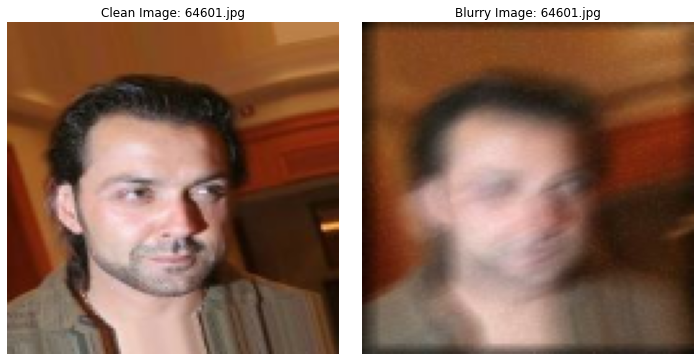

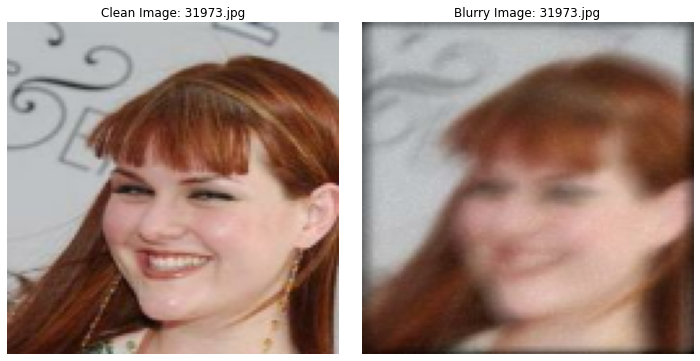

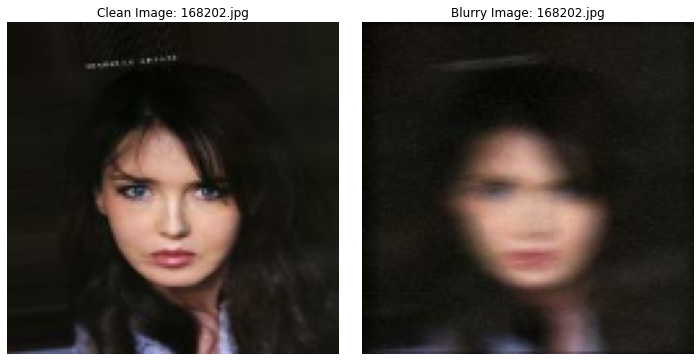

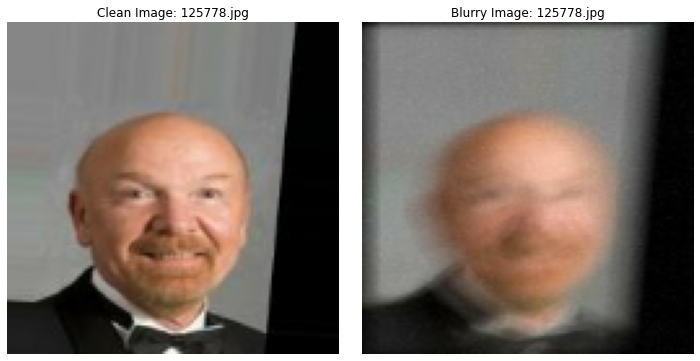

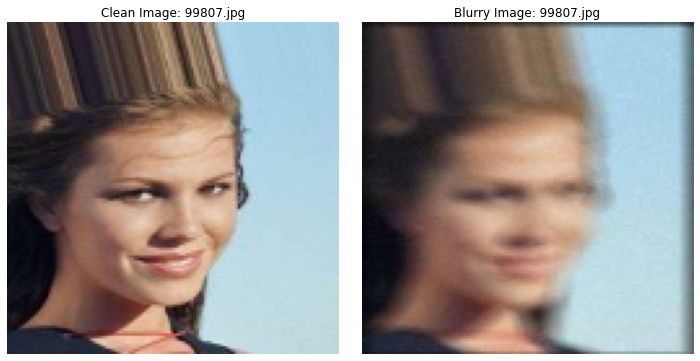

In [ ]:
# Function for loading and preprocessing an image
def load_image(file_path, img_size=(128, 128)):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image

# Function for loading and preprocessing images from the given directories
def load_and_preprocess_images(clean_dir, blurry_dir, num_samples=10000, img_size=(128, 128)):
    clean_files = tf.io.gfile.glob(os.path.join(clean_dir, '*.*'))
    blurry_files = tf.io.gfile.glob(os.path.join(blurry_dir, '*.*'))
    num_images = min(len(clean_files), len(blurry_files), num_samples)
    clean_files = clean_files[:num_images]
    blurry_files = blurry_files[:num_images]
    clean_frames = []
    blurry_frames = []

    for clean_path, blurry_path in zip(clean_files, blurry_files):
        clean_frames.append(load_image(clean_path, img_size).numpy())
        blurry_frames.append(load_image(blurry_path, img_size).numpy())

    return np.array(clean_frames), np.array(blurry_frames), clean_files, blurry_files

# Function to displaying pairs of clean and blurry images
def display_image_pairs(clean_frames, blurry_frames, clean_files, blurry_files, num_pairs=5):
    for i in range(min(num_pairs, len(clean_frames))):
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(clean_frames[i])
        plt.title(f"Clean Image: {os.path.basename(clean_files[i])}")
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(blurry_frames[i])
        plt.title(f"Blurry Image: {os.path.basename(blurry_files[i])}")
        plt.axis('off')
        plt.tight_layout()
        plt.show()

clean_dir = "/kaggle/input/a-curated-list-of-image-deblurring-datasets/DBlur/CelebA/train/sharp"
blurry_dir = "/kaggle/input/a-curated-list-of-image-deblurring-datasets/DBlur/CelebA/train/blur"

clean_frames, blurry_frames, clean_files, blurry_files = load_and_preprocess_images(clean_dir, blurry_dir)
display_image_pairs(clean_frames, blurry_frames, clean_files, blurry_files)


In [ ]:
# Function for calculating statistics for multiple image sets
def calculate_image_statistics(*image_sets):
    stats = {}
    for i, images in enumerate(image_sets):
        stats[f"dataset_{i+1}"] = {
            "mean": np.mean(images, axis=(0, 1, 2)),
            "std_dev": np.std(images, axis=(0, 1, 2)),
            "min": np.min(images),
            "max": np.max(images)
        }
    return stats

print("Analyzing image metrics...")
stats = calculate_image_statistics(clean_frames, blurry_frames)
print(stats)


Analyzing image metrics...
{'dataset_1': {'mean': array([0.1024, 0.1024, 0.1024], dtype=float32), 'std_dev': array([0.32, 0.32, 0.32], dtype=float32), 'min': 0.0, 'max': 1.0}, 'dataset_2': {'mean': array([0.1024, 0.1024, 0.1024], dtype=float32), 'std_dev': array([0.32      , 0.32      , 0.30935946], dtype=float32), 'min': 0.0, 'max': 1.0}}


In [ ]:
# Function for calculating the Laplacian variance of an image (helps in detecting edges since second order derivative)
def calculate_laplacian_variance(image):
    grayscale = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    return cv2.Laplacian(grayscale, cv2.CV_64F).var()

# Function for compaing the blur metrics between clean and blurry images (compares the laplacian variances between clean and blurry images)
def compare_blur_metrics(clean_images, blurry_images):
    clean_blur_scores = [calculate_laplacian_variance(image) for image in clean_images]
    blurry_blur_scores = [calculate_laplacian_variance(image) for image in blurry_images]

    print("Clean Images Blur Metrics:")
    print(f"Mean: {np.mean(clean_blur_scores)}, Std Dev: {np.std(clean_blur_scores)}")
    print(f"Min: {np.min(clean_blur_scores)}, Max: {np.max(clean_blur_scores)}")

    print("Blurry Images Blur Metrics:")
    print(f"Mean: {np.mean(blurry_blur_scores)}, Std Dev: {np.std(blurry_blur_scores)}")
    print(f"Min: {np.min(blurry_blur_scores)}, Max: {np.max(blurry_blur_scores)}")

print("Comparing blur levels...")
compare_blur_metrics(clean_frames, blurry_frames)

Comparing blur levels...
Clean Images Blur Metrics:
Mean: 930.8221177364263, Std Dev: 658.2028124200625
Min: 35.760211046785116, Max: 12172.141789540648
Blurry Images Blur Metrics:
Mean: 141.64406340647415, Std Dev: 78.02710652842029
Min: 45.603083815425634, Max: 1088.3669704459608


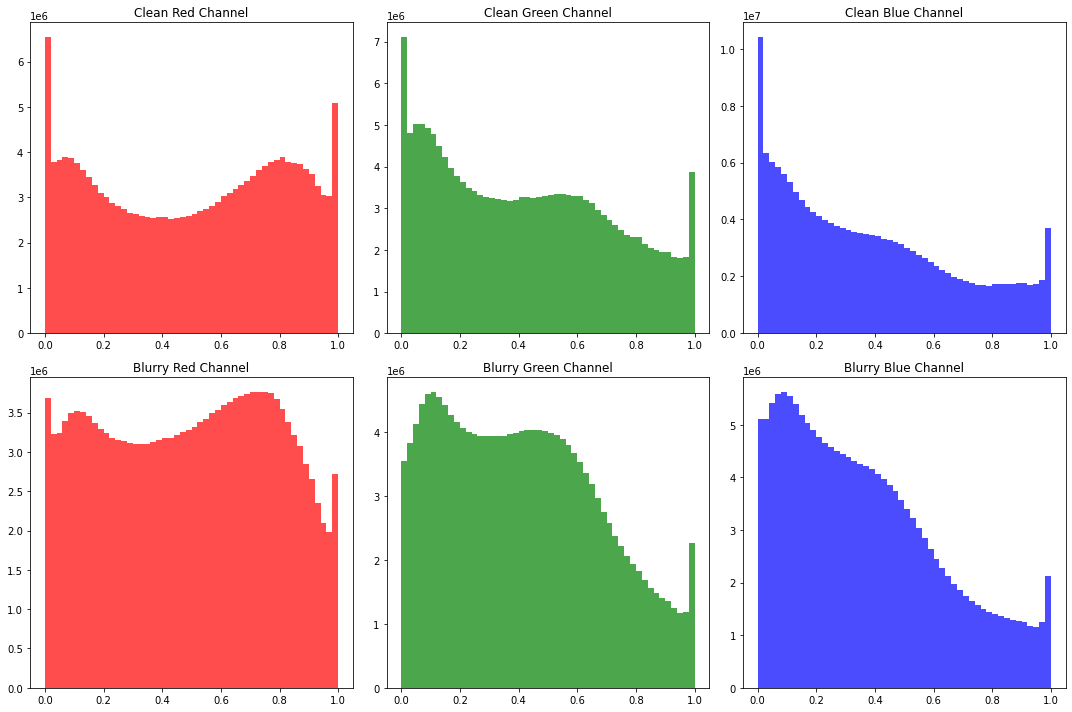

In [ ]:
# Function for analyzing the color channels of clean and blurry images (to analyse the distribution of color channels)
def analyze_color_channels(clean_frames, blurry_frames):
    clean_r = clean_frames[:, :, :, 0]
    clean_g = clean_frames[:, :, :, 1]
    clean_b = clean_frames[:, :, :, 2]
    blurry_r = blurry_frames[:, :, :, 0]
    blurry_g = blurry_frames[:, :, :, 1]
    blurry_b = blurry_frames[:, :, :, 2]
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    axs[0, 0].hist(clean_r.ravel(), bins=50, color='red', alpha=0.7)
    axs[0, 0].set_title('Clean Red Channel')
    axs[0, 1].hist(clean_g.ravel(), bins=50, color='green', alpha=0.7)
    axs[0, 1].set_title('Clean Green Channel')
    axs[0, 2].hist(clean_b.ravel(), bins=50, color='blue', alpha=0.7)
    axs[0, 2].set_title('Clean Blue Channel')
    axs[1, 0].hist(blurry_r.ravel(), bins=50, color='red', alpha=0.7)
    axs[1, 0].set_title('Blurry Red Channel')
    axs[1, 1].hist(blurry_g.ravel(), bins=50, color='green', alpha=0.7)
    axs[1, 1].set_title('Blurry Green Channel')
    axs[1, 2].hist(blurry_b.ravel(), bins=50, color='blue', alpha=0.7)
    axs[1, 2].set_title('Blurry Blue Channel')

    plt.tight_layout()
    plt.show()


analyze_color_channels(clean_frames, blurry_frames)

In [ ]:
#train-test split
x_train, x_test, y_train, y_test = train_test_split(blurry_frames, clean_frames, test_size=0.2, random_state=42)
print(f"Training set size: {x_train.shape[0]}\nTest set size: {x_test.shape[0]}")

Training set size: 8000
Test set size: 2000


In [ ]:
#U-NET

In [ ]:
def unet_model(input_size=(128, 128, 3)):
    inputs = layers.Input(input_size)

    # Encoder (for extracting features and reducing the spatial dimensions)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bridge (connection between encoder and decoder)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)

    # Decoder (to reconstruct the image dimensions using upsampling)
    up4 = layers.UpSampling2D(size=(2, 2))(conv3)
    up4 = layers.concatenate([up4, conv2])
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(up4)
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv4)

    up5 = layers.UpSampling2D(size=(2, 2))(conv4)
    up5 = layers.concatenate([up5, conv1])
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(up5)
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv5)

    outputs = layers.Conv2D(3, 1, activation='sigmoid')(conv5)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

model = unet_model(input_size=(128, 128, 3))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

#training the model
history = model.fit(x_train, y_train, validation_split=0.2, epochs=30, batch_size=32)

model.save('deblur_model.h5')

Epoch 1/30
200/200 [==============================] - 33s 148ms/step - loss: 0.0147 - mae: 0.0790 - val_loss: 0.0068 - val_mae: 0.0532
Epoch 2/30
200/200 [==============================] - 29s 145ms/step - loss: 0.0067 - mae: 0.0519 - val_loss: 0.0063 - val_mae: 0.0499
Epoch 3/30
200/200 [==============================] - 29s 145ms/step - loss: 0.0063 - mae: 0.0499 - val_loss: 0.0059 - val_mae: 0.0477
Epoch 4/30
200/200 [==============================] - 29s 145ms/step - loss: 0.0059 - mae: 0.0479 - val_loss: 0.0055 - val_mae: 0.0458
Epoch 5/30
200/200 [==============================] - 29s 145ms/step - loss: 0.0057 - mae: 0.0470 - val_loss: 0.0054 - val_mae: 0.0454
Epoch 6/30
200/200 [==============================] - 29s 145ms/step - loss: 0.0055 - mae: 0.0460 - val_loss: 0.0052 - val_mae: 0.0440
Epoch 7/30
200/200 [==============================] - 29s 145ms/step - loss: 0.0053 - mae: 0.0450 - val_loss: 0.0052 - val_mae: 0.0438
Epoch 8/30
200/200 [==============================] - 2

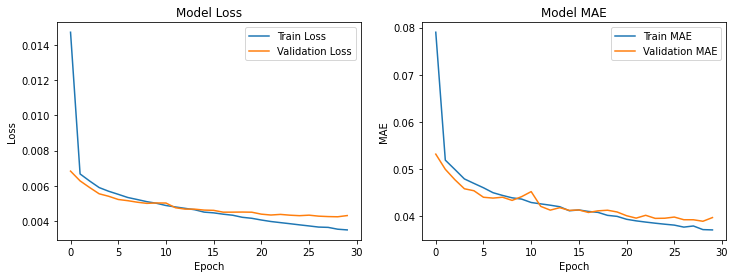

In [ ]:
#plots for visualising the loss and mae graphs during training and validation
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

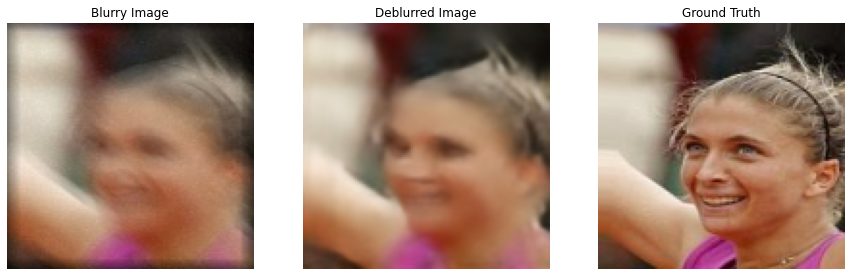

In [ ]:
#Function to visually evaluate the performance of the model
def test_model(model, blurry_image):
    prediction = model.predict(np.expand_dims(blurry_image, axis=0))[0]
    return prediction

sample_index = np.random.randint(0, len(x_test))
sample_blurry = x_test[sample_index]
sample_clean = y_test[sample_index]
deblurred_image = test_model(model, sample_blurry)

plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(sample_blurry)
plt.title('Blurry Image')
plt.axis('off')

plt.subplot(132)
plt.imshow(deblurred_image)
plt.title('Deblurred Image')
plt.axis('off')

plt.subplot(133)
plt.imshow(sample_clean)
plt.title('Ground Truth')
plt.axis('off')

plt.show()


In [ ]:
#To evaluate the performance of the model based on PSNR and SSIM metrics
def evaluate_model_on_test(model, blurry_test, clean_test):
    psnr_values = []
    ssim_values = []

    for i in range(len(blurry_test)):
        deblurred_image = model.predict(np.expand_dims(blurry_test[i], axis=0))[0]
        psnr = calculate_psnr(clean_test[i], deblurred_image, data_range=1.0)
        psnr_values.append(psnr)
        ssim = calculate_ssim(clean_test[i], deblurred_image, multichannel=True, data_range=1.0)
        ssim_values.append(ssim)
    return np.mean(psnr_values), np.mean(ssim_values)

mean_psnr, mean_ssim = evaluate_model_on_test(model, x_test, y_test)

print(f"Mean PSNR on Test Set: {mean_psnr:.2f}")
print(f"Mean SSIM on Test Set: {mean_ssim:.4f}")

Mean PSNR on Test Set: 23.99
Mean SSIM on Test Set: 0.7329


GANs

In [ ]:
# Defining the DeblurGAN class for building and training the model
class DeblurGAN:
    def __init__(self, image_shape):
        self.image_shape = image_shape
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
        self.gan = self.build_gan()

    # Building the generator model
    def build_generator(self):
        inputs = Input(self.image_shape)
        x = Conv2D(64, kernel_size=4, strides=2, padding='same')(inputs)
        x = LeakyReLU(alpha=0.2)(x)
        x = BatchNormalization()(x)
        x = Conv2DTranspose(64, kernel_size=4, strides=2, padding='same')(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = BatchNormalization()(x)
        outputs = Conv2D(3, kernel_size=7, activation='tanh', padding='same')(x)

        return Model(inputs, outputs)

    #Building the discriminator model
    def build_discriminator(self):
        inputs = Input(self.image_shape)
        x = Conv2D(64, kernel_size=4, strides=2, padding='same')(inputs)
        x = LeakyReLU(alpha=0.2)(x)
        x = Conv2D(128, kernel_size=4, strides=2, padding='same')(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Flatten()(x)
        outputs = Dense(1, activation='sigmoid')(x)

        model = Model(inputs, outputs)
        model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

        return model

    #Building the combined GAN model
    def build_gan(self):
        self.discriminator.trainable = False
        inputs = Input(self.image_shape)
        generated_image = self.generator(inputs)
        valid = self.discriminator(generated_image)

        model = Model(inputs, [generated_image, valid])
        model.compile(loss=['mae', 'binary_crossentropy'],
                      loss_weights=[100, 1],
                      optimizer=Adam(0.0002, 0.5))

        return model

    #Training the model
    def train(self, blurry_images, sharp_images, epochs=100, batch_size=32):
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        d_losses = []
        g_losses = []
        psnr_values = []
        ssim_values = []

        for epoch in range(epochs):
            idx = np.random.randint(0, blurry_images.shape[0], batch_size)
            blurry_batch = blurry_images[idx]
            sharp_batch = sharp_images[idx]

            d_loss_real = self.discriminator.train_on_batch(sharp_batch, valid)
            generated_sharp = self.generator.predict(blurry_batch)
            d_loss_fake = self.discriminator.train_on_batch(generated_sharp, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            g_loss = self.gan.train_on_batch(blurry_batch, [sharp_batch, valid])

            d_losses.append(d_loss[0])
            g_losses.append(g_loss[0])

            test_idx = np.random.randint(0, blurry_images.shape[0], 10)
            test_blurry = blurry_images[test_idx]
            test_sharp = sharp_images[test_idx]
            generated_test = self.generator.predict(test_blurry)

            batch_psnr = np.mean([psnr(test_sharp[i], generated_test[i], data_range=2) for i in range(len(test_blurry))])
            batch_ssim = np.mean([ssim(test_sharp[i], generated_test[i], multichannel=True, data_range=2) for i in range(len(test_blurry))])
            psnr_values.append(batch_psnr)
            ssim_values.append(batch_ssim)

            print(f"Epoch {epoch + 1}/{epochs}, "
                  f"D Loss: {d_loss[0]:.4f}, "
                  f"D Acc: {d_loss[1] * 100:.2f}%, "
                  f"G Loss: {g_loss[0]:.4f}, "
                  f"PSNR: {batch_psnr:.2f}, SSIM: {batch_ssim:.4f}")

            if epoch % 10 == 0:
                self.save_sample_images(blurry_batch, sharp_batch, generated_sharp, epoch)

        self.plot_training_progress(d_losses, g_losses, psnr_values, ssim_values)

    def save_sample_images(self, blurry, sharp, generated, epoch):
        plt.figure(figsize=(10, 5))

        for i in range(min(5, blurry.shape[0])):
            plt.subplot(3, 5, i + 1)
            plt.imshow((blurry[i] * 0.5 + 0.5))
            plt.axis('off')

            plt.subplot(3, 5, i + 6)
            plt.imshow((sharp[i] * 0.5 + 0.5))
            plt.axis('off')

            plt.subplot(3, 5, i + 11)
            plt.imshow((generated[i] * 0.5 + 0.5))
            plt.axis('off')

        plt.savefig(f'sample_images_epoch_{epoch}.png')
        plt.close()

    #function for creating plot for indicating the training progress
    def plot_training_progress(self, d_losses, g_losses, psnr_values, ssim_values):
        epochs = range(1, len(d_losses) + 1)

        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.plot(epochs, d_losses, label='Discriminator Loss')
        plt.plot(epochs, g_losses, label='Generator Loss')
        plt.title('Training Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, psnr_values, label='PSNR')
        plt.plot(epochs, ssim_values, label='SSIM')
        plt.title('PSNR and SSIM')
        plt.xlabel('Epochs')
        plt.ylabel('Metrics')
        plt.legend()

        plt.tight_layout()
        plt.savefig('training_progress.png')
        plt.show()


Epoch 1/100, D Loss: 0.7021, D Acc: 14.06%, G Loss: 75.7346, PSNR: 12.28, SSIM: 0.0836
Epoch 2/100, D Loss: 0.4683, D Acc: 100.00%, G Loss: 68.8646, PSNR: 11.40, SSIM: 0.0512
Epoch 3/100, D Loss: 0.3771, D Acc: 100.00%, G Loss: 60.2527, PSNR: 12.18, SSIM: 0.0766
Epoch 4/100, D Loss: 0.2758, D Acc: 100.00%, G Loss: 58.4551, PSNR: 12.67, SSIM: 0.0904
Epoch 5/100, D Loss: 0.2661, D Acc: 100.00%, G Loss: 50.3720, PSNR: 13.27, SSIM: 0.1493
Epoch 6/100, D Loss: 0.2225, D Acc: 100.00%, G Loss: 50.1414, PSNR: 12.87, SSIM: 0.1402
Epoch 7/100, D Loss: 0.1680, D Acc: 100.00%, G Loss: 48.4267, PSNR: 11.64, SSIM: 0.1018
Epoch 8/100, D Loss: 0.1175, D Acc: 100.00%, G Loss: 48.2493, PSNR: 12.52, SSIM: 0.1280
Epoch 9/100, D Loss: 0.1095, D Acc: 100.00%, G Loss: 45.4713, PSNR: 13.12, SSIM: 0.1677
Epoch 10/100, D Loss: 0.0672, D Acc: 100.00%, G Loss: 44.7674, PSNR: 13.55, SSIM: 0.1859
Epoch 11/100, D Loss: 0.0751, D Acc: 100.00%, G Loss: 43.9418, PSNR: 12.27, SSIM: 0.1349
Epoch 12/100, D Loss: 0.0431, D

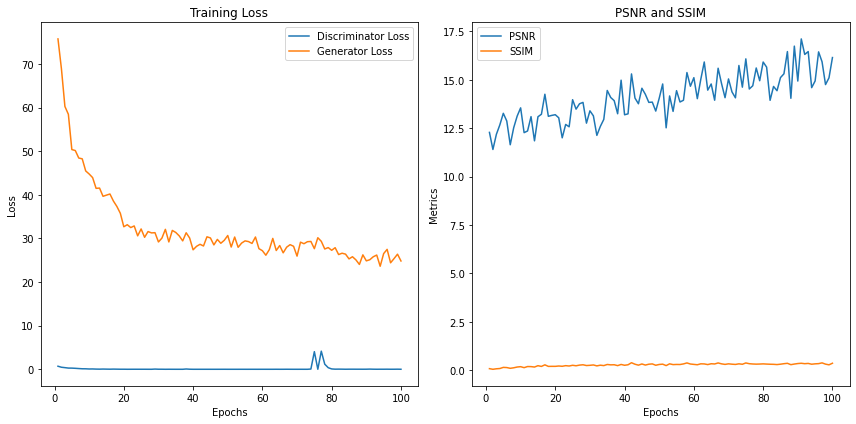

Test PSNR: 9.85
Test SSIM: 0.1834


In [ ]:
from sklearn.model_selection import train_test_split

#Code for training the GAN model and evaluating it based on PSNR a SSIM metrics
image_shape = (128, 128, 3)
deblur_gan = DeblurGAN(image_shape=image_shape)

epochs = 100
batch_size = 32

deblur_gan.train(blurry_images=x_train, sharp_images=y_train, epochs=epochs, batch_size=batch_size)

generated_images = deblur_gan.generator.predict(x_test)
test_psnr = np.mean([psnr(y_test[i], generated_images[i], data_range=1.0) for i in range(len(y_test))])
test_ssim = np.mean([ssim(y_test[i], generated_images[i], multichannel=True, data_range=1.0) for i in range(len(y_test))])

print(f"Test PSNR: {test_psnr:.2f}")
print(f"Test SSIM: {test_ssim:.4f}")

deblur_gan.generator.save("deblur_gan_generator.h5")
deblur_gan.discriminator.save("deblur_gan_discriminator.h5")
deblur_gan.gan.save("deblur_gan_model.h5")


Fine tune VGG16

In [ ]:
IMAGE_SIZE = (128, 128, 3)
LATENT_DIM = 128
VGG16_WEIGHTS_PATH = '/kaggle/input/vgg-16/tensorflow2/default/1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

#Function to build the encoder
def build_encoder(image_size, latent_dim, vgg_weights_path):
    base_encoder = tf.keras.applications.VGG16(input_shape=image_size, weights=None, include_top=False)
    base_encoder.load_weights(vgg_weights_path)

    #freezing all layers except the last 4 layers for fine-tuning
    for layer in base_encoder.layers[:-4]:
        layer.trainable = False
    for layer in base_encoder.layers[-4:]:
        layer.trainable = True

    #define the encoder architecture
    inputs = Input(shape=image_size, name='encoder_input')
    x = base_encoder(inputs)
    x = Flatten()(x)
    latent = Dense(latent_dim, name='latent_vector')(x)

    return Model(inputs, latent, name='encoder')

#Function to build the decoder
def build_decoder(latent_dim):
    latent_inputs = Input(shape=(latent_dim,), name="latent_vector")
    x = Dense(4 * 4 * 512, activation="relu")(latent_inputs)
    x = Reshape((4, 4, 512))(x)

    x = Conv2DTranspose(256, kernel_size=3, strides=2, padding="same", activation="relu")(x)  # 8x8x256
    x = Conv2DTranspose(128, kernel_size=3, strides=2, padding="same", activation="relu")(x)  # 16x16x128
    x = Conv2DTranspose(64, kernel_size=3, strides=2, padding="same", activation="relu")(x)   # 32x32x64
    x = Conv2DTranspose(32, kernel_size=3, strides=2, padding="same", activation="relu")(x)   # 64x64x32
    output = Conv2DTranspose(3, kernel_size=3, strides=2, padding="same", activation="sigmoid")(x)  # 128x128x3

    return Model(latent_inputs, output, name="decoder")

#Function to build the autoencoder by combining encoder and decoder
def build_autoencoder(encoder, decoder):
    inputs = encoder.input
    autoencoder_output = decoder(encoder(inputs))
    return Model(inputs, autoencoder_output, name='autoencoder')


def get_callbacks():
    ## Reducing learning rate on plateau callback
    lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),cooldown=0, patience=5, verbose=1, min_lr=0.5e-6)
    return [lr_reducer]

encoder = build_encoder(IMAGE_SIZE, LATENT_DIM, VGG16_WEIGHTS_PATH)
decoder = build_decoder(LATENT_DIM)

autoencoder = build_autoencoder(encoder, decoder)

autoencoder.compile(optimizer=Adam(), loss='mse', metrics=['mae'])

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

history = autoencoder.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=30,batch_size=16,callbacks=get_callbacks())

Epoch 1/30
450/450 [==============================] - 20s 26ms/step - loss: 0.0458 - mae: 0.1660 - val_loss: 0.0300 - val_mae: 0.1298
Epoch 2/30
450/450 [==============================] - 11s 24ms/step - loss: 0.0268 - mae: 0.1218 - val_loss: 0.0244 - val_mae: 0.1152
Epoch 3/30
450/450 [==============================] - 11s 24ms/step - loss: 0.0233 - mae: 0.1120 - val_loss: 0.0224 - val_mae: 0.1088
Epoch 4/30
450/450 [==============================] - 11s 24ms/step - loss: 0.0214 - mae: 0.1068 - val_loss: 0.0216 - val_mae: 0.1068
Epoch 5/30
450/450 [==============================] - 11s 24ms/step - loss: 0.0201 - mae: 0.1028 - val_loss: 0.0204 - val_mae: 0.1036
Epoch 6/30
450/450 [==============================] - 11s 24ms/step - loss: 0.0189 - mae: 0.0996 - val_loss: 0.0196 - val_mae: 0.1012
Epoch 7/30
450/450 [==============================] - 11s 24ms/step - loss: 0.0174 - mae: 0.0950 - val_loss: 0.0190 - val_mae: 0.0991
Epoch 8/30
450/450 [==============================] - 11s 24ms

In [ ]:
#To evaluate the performance of the model using PSNR and SSIM metrics
predictions = autoencoder.predict(x_test)
psnr_values = np.array([psnr(y_test[i], predictions[i]) for i in range(len(y_test))])
ssim_values = np.array([ssim(y_test[i], predictions[i], multichannel=True) for i in range(len(y_test))])

average_psnr = np.mean(psnr_values)
average_ssim = np.mean(ssim_values)

print("Average PSNR:", average_psnr)
print("Average SSIM:", average_ssim)


Average PSNR: 18.123268987105284
Average SSIM: 0.6247934357953221


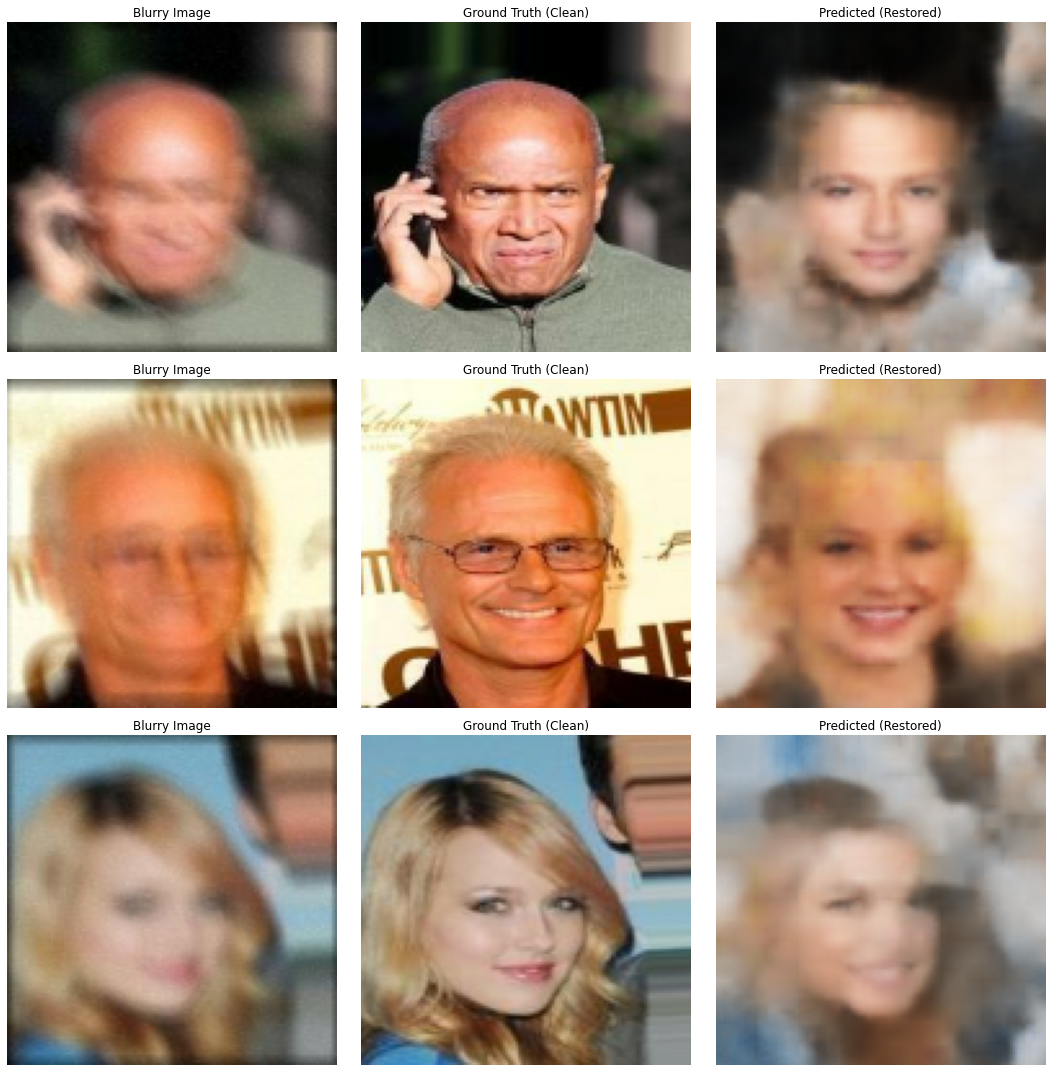

In [ ]:
#To visually evaluate the performance of the model

import matplotlib.pyplot as plt

num_images = 3

indices = np.random.choice(len(x_test), num_images, replace=False)

plt.figure(figsize=(15, 5 * num_images))

for i, idx in enumerate(indices):
    blurry_image = x_test[idx]
    clean_image = y_test[idx]
    predicted_image = predictions[idx]

    plt.subplot(num_images, 3, 3 * i + 1)
    plt.imshow(blurry_image)
    plt.title("Blurry Image")
    plt.axis('off')

    plt.subplot(num_images, 3, 3 * i + 2)
    plt.imshow(clean_image)
    plt.title("Ground Truth (Clean)")
    plt.axis('off')

    plt.subplot(num_images, 3, 3 * i + 3)
    plt.imshow(predicted_image)
    plt.title("Predicted (Restored)")
    plt.axis('off')


plt.tight_layout()
plt.show()


Autoencoders

In [ ]:
#define the configuration for the autoencoder model parameters
class AutoencoderConfig:
    def __init__(self):
        self.image_size = (128, 128, 3)
        self.batch_size = 32
        self.latent_dim = 256
        self.kernel_size = 3
        self.conv_filters = [64, 128, 256]
        self.epochs = 30
        self.min_lr = 1e-6

#code responsible for creating encoder, decoder, and autoencoder models
class AutoencoderBuilder:

    def __init__(self, config):
        self.config = config

    def create_convolutional_block(self, input_tensor, filters, kernel_size, strides=2, activation='relu'):
        #Helper function for creating convolutional layers
        return layers.Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            activation=activation,
            padding='same'
        )(input_tensor)

    def create_transposed_convolutional_block(self, input_tensor, filters, kernel_size, strides=2, activation='relu'):
        #Helper function for creating the transposed convolutional layers
        return layers.Conv2DTranspose(
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            activation=activation,
            padding='same'
        )(input_tensor)

    def build_encoder_model(self, input_shape, filters, latent_dim, kernel_size):
        #Defines the encoder model
        inputs = layers.Input(shape=input_shape, name='encoder_input')
        x = inputs
        for f in filters:
            x = self.create_convolutional_block(x, f, kernel_size)
        encoded_shape = K.int_shape(x)
        x = layers.Flatten()(x)
        latent_vector = layers.Dense(latent_dim, name='latent_representation')(x)
        encoder = models.Model(inputs, latent_vector, name='encoder')
        return encoder, encoded_shape

    def build_decoder_model(self, latent_dim, encoded_shape, filters, kernel_size):
        #Defines the decoder model
        latent_input = layers.Input(shape=(latent_dim,), name='decoder_input')
        x = layers.Dense(np.prod(encoded_shape[1:]))(latent_input)
        x = layers.Reshape(encoded_shape[1:])(x)

        for f in filters[::-1]:
            x = self.create_transposed_convolutional_block(x, f, kernel_size)

        decoded_output = layers.Conv2DTranspose(
            filters=3,
            kernel_size=kernel_size,
            activation='sigmoid',
            padding='same',
            name='decoded_output'
        )(x)
        decoder = models.Model(latent_input, decoded_output, name='decoder')
        return decoder

    def build_autoencoder(self, input_shape, filters, latent_dim, kernel_size):
        """Defines the complete autoencoder by combining encoder and decoder."""
        encoder, encoded_shape = self.build_encoder_model(input_shape, filters, latent_dim, kernel_size)
        decoder = self.build_decoder_model(latent_dim, encoded_shape, filters, kernel_size)

        autoencoder_input = encoder.input
        autoencoder_output = decoder(encoder(autoencoder_input))
        autoencoder = models.Model(autoencoder_input, autoencoder_output, name='autoencoder')

        return autoencoder, encoder, decoder

#Handles the training, callbacks and the training loop
class TrainingManager:

    def __init__(self, model, config):
        self.model = model
        self.config = config

    def compile_model(self):
        self.model.compile(optimizer=Adam(), loss='mse', metrics=['accuracy'])

    def create_lr_scheduler(self):
        return ReduceLROnPlateau(
            factor=np.sqrt(0.1),
            cooldown=0,
            patience=5,
            verbose=1,
            min_lr=self.config.min_lr
        )

    #function for model training
    def train_model(self, train_data, validation_data):
        lr_scheduler = self.create_lr_scheduler()
        history = self.model.fit(
            train_data[0],
            train_data[1],
            validation_data=validation_data,
            epochs=self.config.epochs,
            batch_size=self.config.batch_size,
            callbacks=[lr_scheduler]
        )
        return history

#  Plots for the training and validation loss
def plot_loss(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

#Evaluating the performance based on PSNR and SSIM metrics on the test data
def evaluate_psnr_ssim(model, test_data):
    predictions = model.predict(test_data[0])
    psnr_values = []
    ssim_values = []

    for i in range(len(test_data[0])):
        pred_img = predictions[i]
        true_img = test_data[1][i]

        psnr_value = psnr(true_img, pred_img)
        ssim_value = ssim(true_img, pred_img, multichannel=True)

        psnr_values.append(psnr_value)
        ssim_values.append(ssim_value)

    avg_psnr = np.mean(psnr_values)
    avg_ssim = np.mean(ssim_values)

    print(f'Average PSNR: {avg_psnr:.2f} dB')
    print(f'Average SSIM: {avg_ssim:.4f}')

#Visual evaluation by displaying input blurry image, ground truth image, and the predicted images.
def visual_evaluation(model, blurry_frames, clean_frames, num_images=3):

    for i in range(num_images):
        r = np.random.randint(0, len(clean_frames)-1)
        x, y = blurry_frames[r], clean_frames[r]
        x_inp = x.reshape(1, 128, 128, 3)
        result = model.predict(x_inp)
        result = result.reshape(128, 128, 3)
        fig = plt.figure(figsize=(12, 10))
        fig.subplots_adjust(hspace=0.1, wspace=0.2)
        ax = fig.add_subplot(1, 3, 1)
        ax.imshow(x)
        ax.set_title("Input Image")
        ax.axis('off')
        ax = fig.add_subplot(1, 3, 2)
        ax.imshow(y)
        ax.set_title("Ground Truth")
        ax.axis('off')
        ax = fig.add_subplot(1, 3, 3)
        ax.imshow(result)
        ax.set_title("Predicted Image")
        ax.axis('off')
        plt.show()






# Instantiating the configuration, builder, and training manager
config = AutoencoderConfig()
builder = AutoencoderBuilder(config)
autoencoder_model, encoder_model, decoder_model = builder.build_autoencoder(config.image_size, config.conv_filters, config.latent_dim, config.kernel_size)

# Displaying the model summaries
encoder_model.summary()
decoder_model.summary()
autoencoder_model.summary()

# Training the model
trainer = TrainingManager(autoencoder_model, config)
trainer.compile_model()
history = trainer.train_model((x_train, y_train), (x_train, y_train))

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 16, 16, 256)       295168    
_________________________________________________________________
flatten_2 (Flatten)          (None, 65536)             0         
_________________________________________________________________
latent_representation (Dense (None, 256)               16777472  
Total params: 17,148,288
Trainable params: 17,148,288
Non-trainable params: 0
_______________________________________________

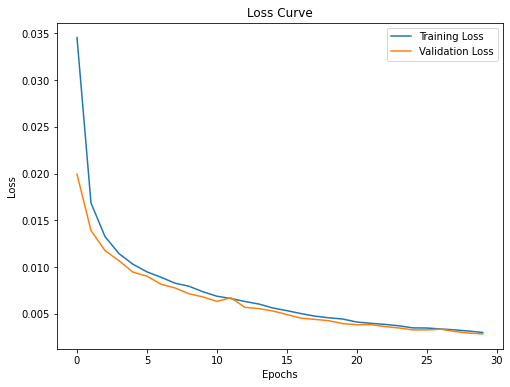

In [ ]:
# Plotting the loss graph over epochs
plot_loss(history)


In [ ]:

# Evaluating performance based on metrics PSNR and SSIM on the test set
evaluate_psnr_ssim(autoencoder_model, (x_test, y_test))

Average PSNR: 26.11 dB
Average SSIM: 0.7719


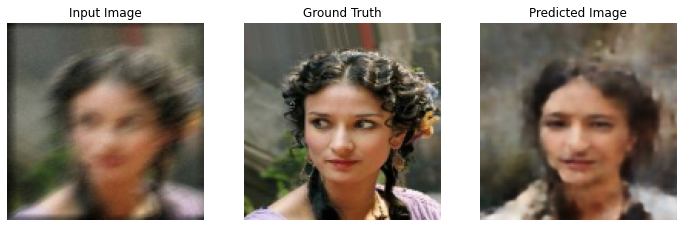

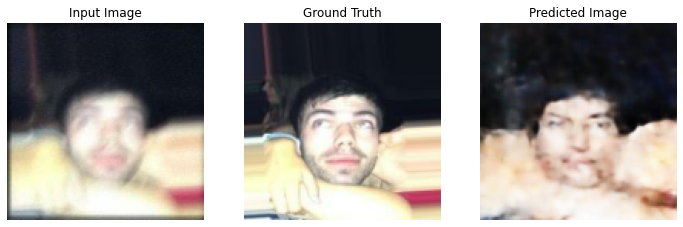

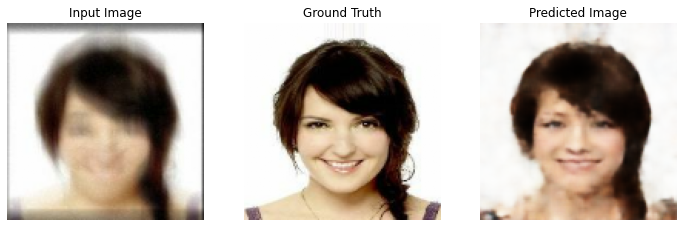

In [ ]:
# Visual evaluation
visual_evaluation(autoencoder_model, x_test, y_test)